In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")

In [3]:
# check if latitude and longitude are values from the UK
#part of policing operation has nan maybe we substitute by "?" as we dont know and

In [4]:
def clean(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop(df[df['station'].isin(["leicestershire",'humberside', 'lancashire','metropolitan','west-midlands'])].index)
    
    station_dict = {}
    
    # Fill in missing Latitude and Longitude values based on station averages
    df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].fillna(value=df.groupby('station')[['Latitude', 'Longitude']].transform('mean'))
    
    df['Part of a policing operation'] = df['Part of a policing operation'].fillna(False)
    df['Part of a policing operation'] = df['Part of a policing operation'].astype(bool)

    df['Outcome linked to object of search'] = df['Outcome linked to object of search'].fillna(False)

    df['Removal of more than just outer clothing'] = df['Removal of more than just outer clothing'].fillna(False)

    df['Legislation'] = df['Legislation'].fillna('unknown')
    

    # Add new columns for day, year, month, and day of the week
    df['day'] = df['Date'].dt.day
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['hour'] = df['Date'].dt.hour
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']

    # create a new column called "success" with 1 if the outcome is in the list of successful outcomes, 0 otherwise
    df['success'] = df.apply(lambda x: True if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else False, axis=1)


    df=df.dropna()
    return df

    
    
df_new = clean(df)

In [10]:
# Select features and target variable
features  = ['Type', 'Part of a policing operation', 'Latitude', 'Longitude',
            'Gender', 'Age range',
            'Officer-defined ethnicity', 'Legislation', 'Object of search',
            'station', 'day', 'year', 'month', 'day_of_week', 'hour']

target = 'success'

numerical_features= ['Part of a policing operation', 'Latitude', 'Longitude', 'day', 'month', 'day_of_week', 'hour']

#categorical_features =['Type', 'Part of a policing operation','Gender', 'Age range',
#                       'Officer-defined ethnicity','Legislation', 'Object of search','station']

categorical_features = ['Type', 'Legislation', 'Object of search']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_new[features], df_new[target], test_size=0.33, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))])



# Fit model on training data
pipeline.fit(X_train, y_train)

# Make predictions on testing data
y_pred = pipeline.predict(X_test)

# Print f1 score, recall score, and precision score
print('F1 score:', f1_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))
print('Precision score:', precision_score(y_test, y_pred))



F1 score: 0.3511399218758181
Recall score: 0.791361812603257
Precision score: 0.2256271533161068


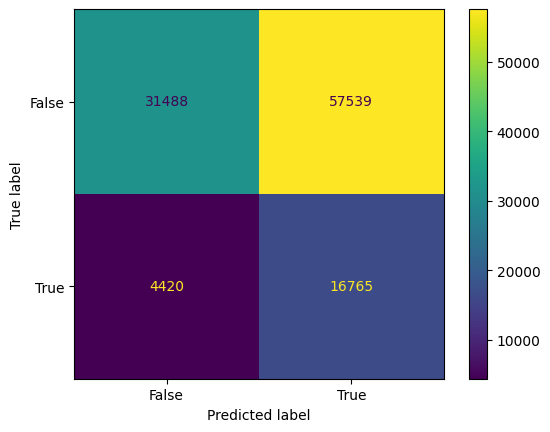

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
plt.savefig("confusion_matrix.jpg", bbox_inches='tight')

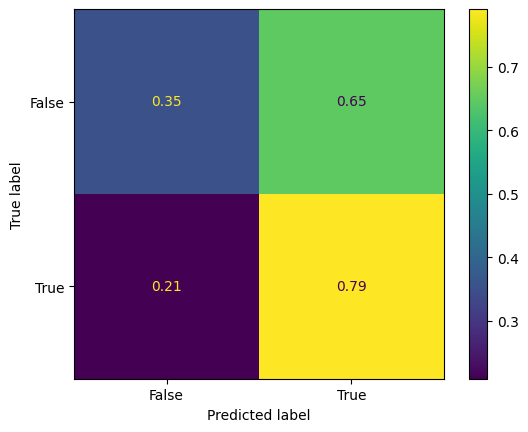

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
plt.savefig("confusion_matrix.jpg", bbox_inches='tight')